# 多元卡尔曼滤波器

过滤多个随机变量

In [1]:
%matplotlib inline

#format the book
import lean.book_format as book_format
book_format.set_style()

## 介绍

我们现在准备研究和实现完整的多元形式的卡尔曼滤波器。在上一章中，我们学会了如何用多元高斯表达多个随机变量之间的相关性，例如飞机的位置和速度。我们也了解了变量之间的相关性如何显著的改变后验估计。如果我们只是粗略知道飞机的位置和速度，但是它们是相关的，那么我们新的估计值是可以非常准确的。

我更喜欢通过几个工作示例让你对滤波器原理产生直觉感受。我将会掩盖很多不必要的问题。我向您展示的某些内容仅适用于特殊情况，而其他内容则“神奇”-不清楚我是如何得出某个结果的。如果我从严格的、广义的方程开始，你会对所有这些术语的含义以及如何将它们应用于你的问题感到挠头。在后面的章节中，我将提供一个更严格的数学基础，届时我将不得不纠正我在本章中所做的近似值，或者提供我在这里没有涉及的其他信息。

为了实现这一目标，我们将自己限制在可以用牛顿运动方程描述的问题子集上。这些滤波器称为离散化连续时间运动滤波器。在卡尔曼滤波数学一章中，我们将开发非牛顿系统的数学。

## 牛顿运动方程

牛顿的运动方程告诉我们，给定一个系统的恒定速度 𝑣 ，我们可以计算出它在时间 𝑡 后的位置 𝑥 ：

$$x = vt + x_0$$

例如，如果我们从位置 13 开始，我们的速度是 10 m/s，我们行进 12 秒，我们的最终位置是 133（ 10×12+13 ）。

我们可以将恒定加速度与这个方程结合起来

$$x = \frac{1}{2}at^2 + v_0t + x_0$$

如果我们假设恒定的加加速度，我们会得到

$$x = \frac{1}{6}jt^3 +  \frac{1}{2}a_0 t^2 + v_0 t + x_0$$

这些方程是通过微积分方程生成的。给定一个恒定的速度 v，我们可以用方程计算随时间推移的行进距离

$$x = vt + x_0$$

我们可以推导出来

$$\begin{aligned} v &= \frac{dx}{dt}\\
dx &= v\, dt \\
\int_{x_0}^x\, dx &= \int_0^t v\, dt\\
x - x_0 &= vt - 0\\
x &= vt + x_0\end{aligned}$$

当您设计卡尔曼滤波器时，您首先要从描述系统动力学的微分方程组开始。大多数微分方程组不容易以这种方式积分。我们从牛顿方程开始，因为我们可以积分并获得闭式解，这使得卡尔曼滤波器更容易设计。另一个好处是牛顿方程是用于跟踪移动物体的正确方程，这是卡尔曼滤波器的主要用途之一。

## 卡尔曼滤波算法

该算法与我们每章中使用的贝叶斯滤波算法相同。更新步骤稍微复杂一些，但当我们开始接触它时，我会解释原因。

初始化

- 1. 初始化滤波器状态(初始化状态变量)
- 2. 初始化状态变量的信念(协方差矩阵)

预测

- 1. 使用过程模型去预测下一个时间步的状态(获得先验估计值)
- 2. 调整信念以解释预测中的不确定性(先验估计的协方差矩阵)

更新

- 1. 获取测量值以及与准确性相关的信念(传感器的测量方差)
- 2. 计算测量值与先验估计的残差
- 3. 根据测量和先验估计的信念，计算卡尔曼增益系数
- 4. 根据卡尔曼增益设置新的状态(后验估计值)
- 5. 根据测量的确定性，更新状态的信念(后验估计的协方差)

提醒一下，以下是该算法的图形描述：

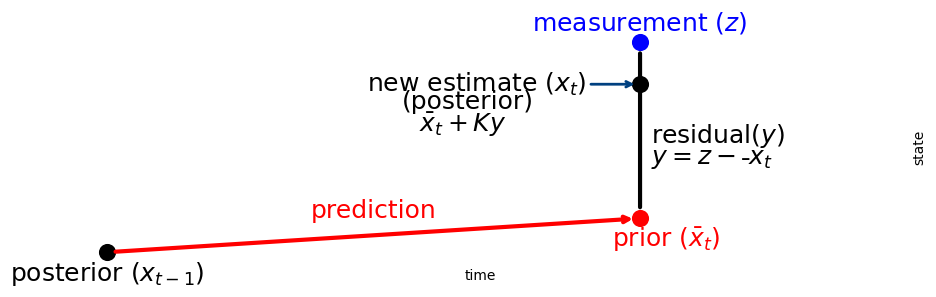

In [3]:
import lean.kf_book.book_plots as book_plots
book_plots.show_residual_chart()

单变量卡尔曼滤波器用单变量高斯表示状态。当然，多元卡尔曼滤波器将使用多元高斯滤波器来表示状态。我们在上一章中了解到，多元高斯使用向量表示均值，矩阵表示协方差。这意味着卡尔曼滤波器需要使用线性代数来执行估计。

我不希望你记住这些方程，但我在下面列出了单变量和多变量方程。它们非常相似。

<u>**预测**</u>

$\begin{array}{|l|l|l|}
\hline
\text{单变量} & \text{单变量} & \text{多元}\\
& \text{(卡尔曼形式)} & \\
\hline
\bar \mu = \mu + \mu_{f_x} & \bar x = x + dx & \bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}\\
\bar\sigma^2 = \sigma_x^2 + \sigma_{f_x}^2 & \bar P = P + Q & \bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q \\
\hline
\end{array}$

不用担心线性代数的细节，我们可以看到：

$\mathbf x,\, \mathbf P$ 是状态的均值和协方差。 它们对应于 $x$ and $\sigma^2$.

$\mathbf F$ 是 *状态转移矩阵*. 当与 $\bf x$ 相乘，它计算得到先验。

$\mathbf Q$ 过程模型的协方差矩阵. 它对应于 $\sigma^2_{f_x}$。

$\mathbf B$ and $\mathbf u$ 对我们来说是新的. 它允许我们对系统的控制输入进行建模。


<u>**更新**</u>

$\begin{array}{|l|l|l|}
\hline
\text{单变量} & \text{单变量} & \text{多元}\\
& \text{(卡尔曼形式)} & \\
\hline
& y = z - \bar x & \mathbf y = \mathbf z - \mathbf{H\bar x} \\
& K = \frac{\bar P}{\bar P+R}&
\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1} \\
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2} & x = \bar x + Ky & \mathbf x = \bar{\mathbf x} + \mathbf{Ky} \\
\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} & P = (1-K)\bar P &
\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}} \\
\hline
\end{array}$

$\mathbf H$ 是测量函数. 我们在本书中还没有见到过它，我会稍后解释它。如果你想象一下把 $\mathbf H$ f从方程中删除, 你应该能够看到这些方程也是相似的。

$\mathbf z,\, \mathbf R$ 是测量的均值和噪声协方差. 在单变量滤波器中，它对应单变量的 $z$ and $\sigma_z^2$ 。(我已经用 $x$ 代替了单变量方程的 $\mu$，以使符号尽可能相似)。

$\mathbf y$ and $\mathbf K$ 是残差和卡尔曼增益。

细节将会与单变量滤波器不同，因为它们是向量和矩阵。但是概念完全相同。

- 使用高斯来表示我们的状态的估计和误差
- 使用高斯来表示测量值和它的误差
- 使用高斯去表示过程模型
- 使用过程模型去预测下一个时间步的状态(先验估计)
- 根据测量和先验估计形成后验估计

作为设计师，你的工作是设计状态 $\left(\mathbf x, \mathbf P\right)$, 过程 $\left(\mathbf F, \mathbf Q\right)$, 测量 $\left(\mathbf z, \mathbf R\right)$, 和测量函数 $\mathbf H$. 如果系统有控制输入，比如机器人，你也将会设计 $\mathbf B$ and $\mathbf u$.

我已经将卡尔曼滤波器的方程编程为 predict 和 update 函数在FilterPy 模块中。您将使用以下命令导入它们：

```python
from filterpy.kalman import predict, update
```

## 跟踪狗

让我们回到我们老生常谈的追踪狗的问题。这次我们将包括上一章的基本见解，并使用隐藏变量来改进我们的估计。我可以从数学开始，但让我们实现一个过滤器，边走边学。从表面上看，数学是不同的，也许比前几章更复杂，但想法都是一样的——我们只是多元高斯的乘法和加法。

我们首先编写一个狗的运动仿真。这个仿真将会运行count个步骤，在每个时间步中，它向前移动接近1m。在每个步骤中，速度将会根据过程方差process_var而变化。更新位置之后，我们获取一个测量值，假设传感器的方差是z_var。该函数返回一个numpy数组，一个是位置(先验)，一个是测量值。

In [4]:
import math
import numpy as np
from numpy.random import randn

# 模拟狗的运动和传感器测量
def compute_dog_data(z_var, process_var, count=1, dt=1.0):
    x, vel = 0.0, 1.0                               # 狗的初始位置和速度
    z_std = math.sqrt(z_var)                        # 传感器测量的标准差
    p_std = math.sqrt(process_var)                  # 过程模型的标准差
    
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)                 # 每个时刻的实际速度
        x += v * dt                                 # 每个时刻的实际位置
        
        xs.append(x)                                # 过程模型预测的狗的位置，先验估计
        zs.append(x + randn() * z_std)              # 传感器测量的狗的位置，证据或者可能性
        
    return np.array(xs), np.array(zs)

### 预测步骤

对于预测，我们需要设计状态变量和它的协方差、过程模型和过程噪声，以及可选的控制输入。我们会按顺序处理它们。

#### 设计状态变量

我们之前使用高斯在一个维度上跟踪狗的位置。均值 $(\mu)$表示最有可能的位置，方差($\sigma^2$)表示位置的概率分布。位置是系统的状态，我们称$\mu$ 为 *状态变量*。

在这个问题中，我们将跟踪狗的位置和速度。这要求我们去使用由状态向量$\mathbf x$以及相应的协方差矩阵$\mathbf P$表示的多元高斯。

状态变量要么是*观察变量*-由传感器直接测量，要么是由观察变量推断的*隐藏变量*。对于我们狗的跟踪问题，传感器仅仅测量位置信息，因此位置是观察变量、速度是隐藏变量。我们将很快学习如何跟踪隐藏变量。

重要的是要了解跟踪位置和速度是一种设计选择，其含义和假设我们尚未准备好探索。例如，我们还可以跟踪加速度，甚至是颠簸。现在，回想一下，在上一章中，我们展示了在协方差矩阵中包含速度会导致位置方差小得多。我们将在本章后面学习卡尔曼滤波器如何计算隐藏变量的估计值。

在单变量章节中，我们用标量值表示狗的位置（例如 $\mu=3.27$）。在上一章中，我们学习了对多个变量使用多元高斯。例如，如果我们想指定 10.0 m 的位置和 4.5 m/s 的速度，我们可以这样写：

$$\mu = \begin{bmatrix}10.0\\4.5\end{bmatrix}$$

卡尔曼滤波器是使用线性代数实现的。我们使用$n\times 1$的矩阵(称为一个*向量*)去存储$n$ 个状态变量。对于狗跟踪问题，我们使用 $x$ 表示位置，使用 $x$ 的一阶导数 $\dot x$ 表示速度。我使用牛顿的点符号来表示导数;$\dot x$ 表示 x 相对于 t 的一阶导数：$\dot x = \frac{dx}{dt}$。卡尔曼滤波方程使用 $\mathbf x$ 作为状态，因此我们将 $\mathbf x$ 定义为：

$$\mathbf x =\begin{bmatrix}x \\ \dot x\end{bmatrix}$$

我们使用 $\mathbf x$ 而不是 $\mu$，但要认识到这是多元高斯的平均值。

另一种写法是$\mathbf x =\begin{bmatrix}x & \dot x\end{bmatrix}^\mathsf T$，因为行向量的转置是列向量。这种表示法在文本中更易于使用，因为它占用的垂直空间更小。

$\mathbf x$ 和位置 $x$ 巧合的具有相同的名称。如果我们在y轴方向对狗进行跟踪，我们会写 $\mathbf x =\begin{bmatrix}y & \dot y\end{bmatrix}^\mathsf T$, 而不是  $\mathbf y =\begin{bmatrix}y & \dot y\end{bmatrix}^\mathsf T$. $\mathbf x$ 在卡尔曼滤波器文献中是一个标准的状态变量名称。并且，我们不会改变它以赋予它更有意义的名称。这种命名的一致性有利于与同行之间的交流。

让我们对此进行编码，初始化 `x`非常简单。

In [5]:
# 狗的初始位置和速度
x = np.array([[10.0],
              [4.50]])
x

array([[10. ],
       [ 4.5]])

我经常在代码中使用转置将行矩阵转换为列向量，因为我发现输入和阅读更容易：

In [6]:
x = np.array([[10.0, 4.50]]).T
x

array([[10. ],
       [ 4.5]])

但是，NumPy 将 1D 数组识别为向量(列向量)，因此我可以使用 1D 数组简化此行。

In [12]:
x = np.array([10.0, 4.50])
x, x.shape

(array([10. ,  4.5]), (2,))

所有数组的元素具有相同的数据类型，通常是float和int类型。如果列表中所有元素的类型都是int，那么创建的array的数据类型也是int，否则的话，它将是float类型的数组。我经常为了方便会指定一个数字为浮点型。

In [13]:
np.array([1.0, 0, 0, 0, 0, 0])

array([1., 0., 0., 0., 0., 0.])

以下是一些示例。

In [14]:
A = np.array([[1, 2], [3, 4]])          # 维度是2*2
x = np.array([[10.0], [4.50]])          # 维度是2*1

# 矩阵乘法
print(np.dot(A, x))                     # 维度是2*1
print()

[[19.]
 [48.]]



在 Python 3.5+ 中，我们有矩阵乘法 @，其中`np.dot(A, B) == A @ B`。它可能比你可能意识到的有用性要小一些，因为它要求`A` 和 `B`都是数组。在本书的数学中，这些变量中的一些变量是标量，因此  @ 的有效性经常丢失。

In [16]:
# 可选择的矩阵乘法
print(A @ x)
print()

x = np.array([[10.0, 4.50]]).T
print(A @ x)
print()

# 默认就是个列向量
x = np.array([10.0, 4.50])
print(A @ x)
print()


[[19.]
 [48.]]

[[19.]
 [48.]]

[19. 48.]



最后一个返回一个 1D 数组，但我编写了卡尔曼滤波器类来处理这个问题。回想起来，这可能会导致混乱，但它确实有效。

#### 设计状态协方差

状态高斯的另一半是协方差矩阵 $\mathbf P$。在单变量卡尔曼滤波器中，我们为 $\sigma^2$ 指定了一个初始值，然后滤波器负责在将测量值添加到滤波器时更新其值。同样的事情发生在多维卡尔曼滤波器中。我们为 $\mathbf P$ 指定一个初始值，过滤器在每个时间步去更新它。

我们需要将方差设置为合理的值。例如，如果我们相当不确信初始位置，我们可以设置 $\sigma_\mathtt{pos}^2=500 m^2$。狗的最高速度为21 m/s。因此，在缺乏任何其它信息时，我们对速度可以设置为$3\sigma_\mathtt{vel}=21$, or $\sigma_\mathtt{vel}^2=7^2=49$。

在上一章中，我们展示了位置和速度是相关的。但是，对于狗来说，它们的相关性如何？我们不知道。正如我们将看到的，过滤器会为我们计算这一点，因此我将协方差初始化为零。当然，如果你知道协方差，你应该使用它们。

回想一下，协方差矩阵的对角线包含每个变量的方差，非对角线元素包含协方差。因此，我们有：

$$
\mathbf P = \begin{bmatrix}500 & 0 \\ 0&49\end{bmatrix}
$$

我们可以使用 numpy.diag，它根据对角线的值创建一个对角矩阵。回想一下线性代数，对角矩阵是在非对角元素中具有零的矩阵。

In [17]:
# 状态变量的协方差矩阵
P = np.diag([500.0, 49.0])
P

array([[500.,   0.],
       [  0.,  49.]])

我本可以写：

In [18]:
P = np.array([[500., 0.],
              [0., 49.]])
P

array([[500.,   0.],
       [  0.,  49.]])

我们完成了。我们将滤波器的状态表示为多元高斯，并在代码中实现。

#### 设计过程模型
